In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
import os

In [30]:
# Load Data
train_data = pd.read_csv("./data/train.csv", index_col=0)
test_data = pd.read_csv("./data/test.csv", index_col=0)
validation_data = pd.read_csv("./data/validation.csv", index_col=0)

In [31]:
state_2 = {}
def preprocess_phase_2(data):

    # Similar preprocessing as above but without fitting new encoders/scalers
    columns_to_drop = ['Customer ID', 'Quarter', 'Country', 'State', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Population', 'Senior Citizen', 'Under 30']
    data.drop(columns=columns_to_drop, axis=1, inplace=True)

    data["Stickiness Score"] = data["Device Protection Plan"] + data["Premium Tech Support"] + data["Streaming TV"] + data["Streaming Movies"] + data["Streaming Music"]+ data["Online Security"] + data["Online Backup"] + data["Unlimited Data"]
    data.drop(columns=["Device Protection Plan", "Premium Tech Support", "Streaming TV", "Streaming Movies", "Streaming Music", "Online Security", "Online Backup", "Unlimited Data"], axis=1, inplace=True)

    data["Churn Category"].fillna("No Category", inplace=True)
    data["Churn Reason"].fillna("Did not Churn", inplace=True)
    data["Offer"].fillna("None", inplace=True)
    
    # Transform the Churn Reason column into Embeddings
    sentence_transformer_model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = sentence_transformer_model.encode(data["Churn Reason"])

    umap_reducer = umap.UMAP(
    n_components=2, 
    random_state=42,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine'
    )
    embeddings_2d = umap_reducer.fit_transform(embeddings)

    # HDBSCAN for Clustering
    hdbscan_clusterer = hdbscan.HDBSCAN(
        min_cluster_size=15,
        metric='euclidean',
        cluster_selection_method='eom'
    )

    data['Reason_Cluster_ID'] = hdbscan_clusterer.fit_predict(embeddings_2d)

    if -1 in data['Reason_Cluster_ID'].values:
        data['Reason_Cluster_ID'] = data['Reason_Cluster_ID'] + 1
    
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(
        embeddings_2d[:, 0],
        embeddings_2d[:, 1],
        c=data["Reason_Cluster_ID"],
        cmap='tab20',
        s=40,
        alpha=0.85
    )

    plt.colorbar(scatter, label="Cluster ID")
    plt.title("UMAP + HDBSCAN Clusters for Churn Reasons", fontsize=15)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.grid(alpha=0.3)
    plt.show()
    
    cluster_reason_map = {}
    for cluster_id in data['Reason_Cluster_ID'].unique():
    # Find most common text reason in this cluster
        subset = data[data['Reason_Cluster_ID'] == cluster_id]
        most_common_reason = subset['Churn Reason'].mode()[0]
        cluster_reason_map[cluster_id] = most_common_reason

    data.drop(columns=["Churn Reason","Churn Category", "Churn Score", "Customer Status"], axis=1, inplace=True)

    object_cols = data.select_dtypes(include=['object']).columns.tolist()
    for col in object_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        state_2[col] = {"classes": le.classes_, "le": le}

    boolean_columns = data.columns[data.nunique() == 2].tolist()
    scaling_columns = data.drop(columns=boolean_columns, axis=1)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(scaling_columns)
    scaled_data = pd.DataFrame(scaled_data, columns=scaling_columns.columns, index=data.index)
    
    final_data = pd.concat([scaled_data, data[boolean_columns]], axis=1)

    X = final_data.drop(columns=["Reason_Cluster_ID"], axis=1)
    y = final_data["Reason_Cluster_ID"]

    return X, y, cluster_reason_map

/tmp/ipykernel_4578/1282356374.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Churn Category"].fillna("No Category", inplace=True)
/tmp/ipykernel_4578/1282356374.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

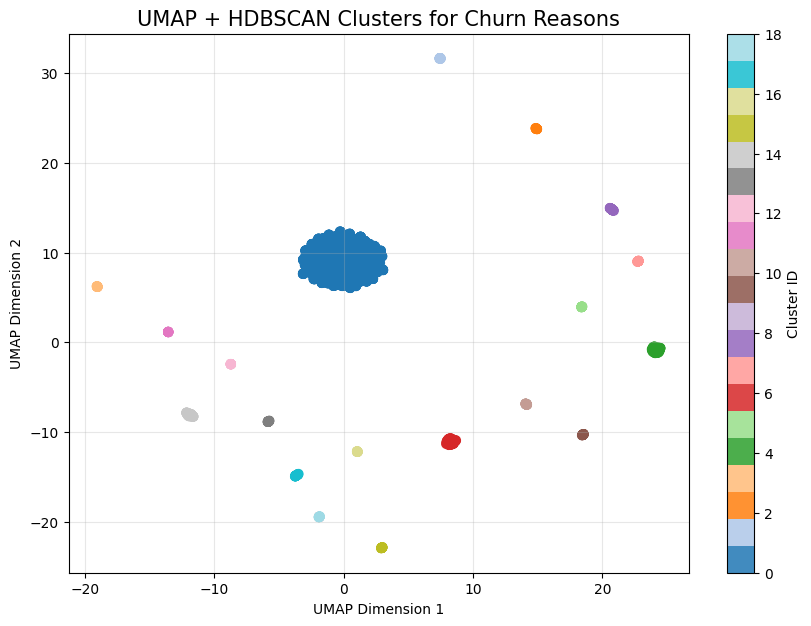

/tmp/ipykernel_4578/1282356374.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Churn Category"].fillna("No Category", inplace=True)
/tmp/ipykernel_4578/1282356374.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

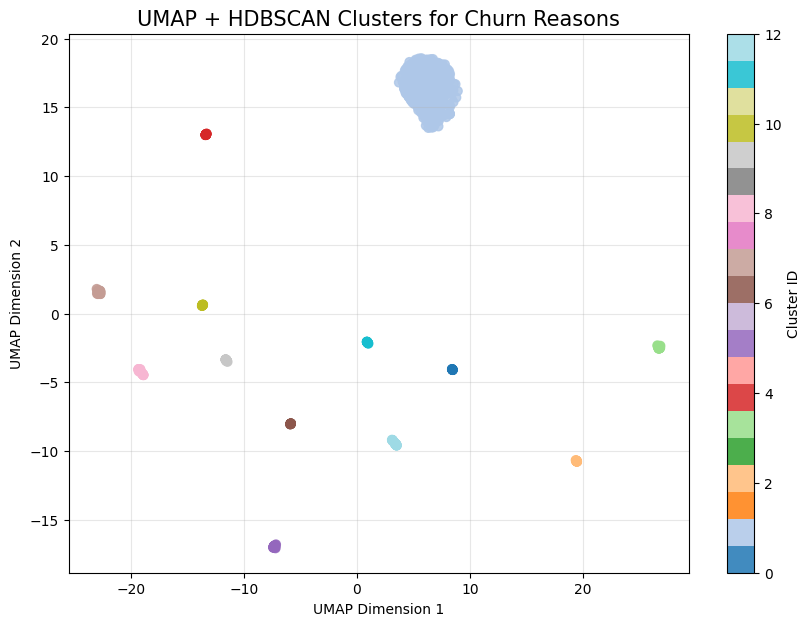

/tmp/ipykernel_4578/1282356374.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Churn Category"].fillna("No Category", inplace=True)
/tmp/ipykernel_4578/1282356374.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

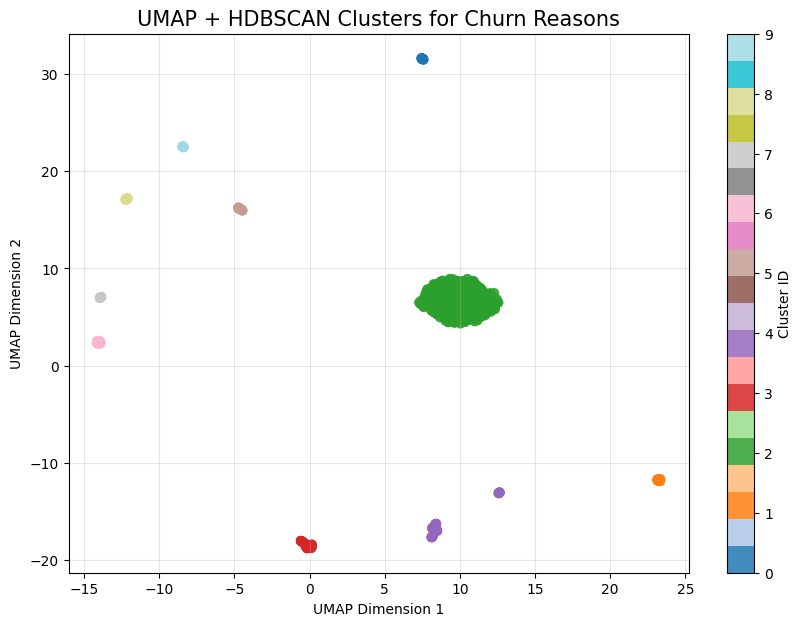

In [32]:
X_train, y_train, cluster_map_train = preprocess_phase_2(train_data)
X_test, y_test, cluster_map_test = preprocess_phase_2(test_data)
X_validation, y_validation, cluster_map_validation = preprocess_phase_2(validation_data)

In [37]:
def train_evaluate_visualize(X_train, y_train, cluster_map_train, X_test, y_test, cluster_map_test):
    # Split Data
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        "SVM": SVC(probability=True, random_state=42)
    }

    results = []
    roc_data = {}

    print("\n" + "="*40)
    print("STARTING MODEL TRAINING")
    print("="*40)

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)
        
        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # ROC-AUC (One-vs-Rest)
        try:
            auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
        except:
            auc = 0.0
            
        results.append({
            "Model": name, 
            "Accuracy": acc, 
            "Precision": prec, 
            "Recall": rec, 
            "F1 Score": f1, 
            "ROC-AUC": auc
        })
        roc_data[name] = (y_test, y_prob)

    # --- RESULTS TABLE (PANDAS DATAFRAME) ---
    results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False).set_index('Model')
    # Round metrics for display
    results_display_df = results_df.copy()
    for col in results_display_df.columns:
        results_display_df[col] = results_display_df[col].map('{:.4f}'.format)
    
    print("\n" + "="*40)
    print("PERFORMANCE METRICS")
    print("="*40)
    print(results_display_df)

    # --- VISUALIZATION 1: SAVABLE TABLE FIGURE ---
    fig_table, ax_table = plt.subplots(figsize=(10, 3))
    ax_table.axis('off') # Hide axes for a clean table look
    ax_table.axis('tight')

    # Create the table
    # cellText is the data values, colLabels are the column names
    table = ax_table.table(
        cellText=results_display_df.values,
        colLabels=results_display_df.columns,
        rowLabels=results_display_df.index,
        loc='center',
        cellLoc='center',
        bbox=[0, 0, 1, 1] # Fill the whole figure area
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    fig_table.suptitle('Model Performance Summary for Churn Reason Prediction', y=0.98, fontsize=12)

    # Save the table figure
    # table_path = os.path.join(OUTPUT_DIR, "performance_metrics_table.png")
    fig_table.savefig("./figs/performance_phase_2.png", bbox_inches='tight', dpi=300)
    # print(f"\nPerformance Metrics Table Figure saved to: {table_path}")
    plt.close(fig_table) # Close the table figure to prevent display issues

    # --- VISUALIZATION 1: ACCURACY COMPARISON ---
    plt.figure(figsize=(10, 5))
    sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
    plt.title("Model Accuracy Comparison (Churn Reason)")
    plt.ylim(0, 1.0)
    plt.ylabel("Accuracy Score")
    plt.show()

    # --- VISUALIZATION 2: ROC CURVES ---
    plt.figure(figsize=(10, 8))
    classes = np.unique(y)
    
    for name, (y_test_iter, y_prob_iter) in roc_data.items():
        # Binarize for multiclass ROC
        y_test_bin = label_binarize(y_test_iter, classes=classes)
        # Micro-average ROC
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob_iter.ravel())
        plt.plot(fpr, tpr, lw=2, label=f'{name}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curves (Micro-Averaged)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # --- VERIFICATION: ACTUAL vs PREDICTED REASONS ---
    print("\n" + "="*40)
    print("REASON PREDICTION CHECK (Sample)")
    print("="*40)
    
    # Pick the best model (top of results_df)
    best_model_name = results_df.iloc[0]['Model']
    best_model = models[best_model_name]
    
    # Predict on Test Set
    test_preds = best_model.predict(X_test)
    
    # Create comparison dataframe
    comparison = pd.DataFrame({
        'Actual Cluster': y_test,
        'Predicted Cluster': test_preds
    })
    
    # Map back to English
    comparison['Actual Reason'] = comparison['Actual Cluster'].map(cluster_map)
    comparison['Predicted Reason'] = comparison['Predicted Cluster'].map(cluster_map)
    comparison['Match'] = comparison['Actual Cluster'] == comparison['Predicted Cluster']
    
    # Show sample
    pd.set_option('display.max_colwidth', 100)
    print(f"Using Best Model: {best_model_name}")
    print(comparison[['Actual Reason', 'Predicted Reason', 'Match']].head(10))
    print("\n" + "="*40)



STARTING MODEL TRAINING
Training Random Forest...
Training XGBoost...


/home/kushal-patel/My Space/NCSU/CSC 522 - ALDA/Project/Cutomer-Churn-Prediction/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:18:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training SVM...

PERFORMANCE METRICS
              Accuracy Precision  Recall F1 Score ROC-AUC
Model                                                    
SVM             0.8368    0.7002  0.8368   0.7624  0.9178
Random Forest   0.8297    0.7454  0.8297   0.7782  0.9324
XGBoost         0.8282    0.7733  0.8282   0.7972  0.9342


/tmp/ipykernel_4578/1607341556.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")


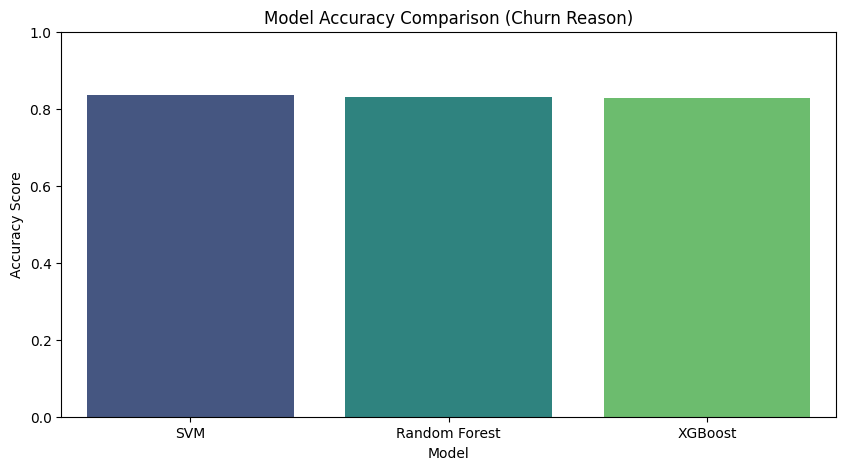

ValueError: Found input variables with inconsistent numbers of samples: [26771, 5636]

<Figure size 1000x800 with 0 Axes>

In [38]:
train_evaluate_visualize(X_train, y_train, cluster_map_train, X_test, y_test, cluster_map_test)